# Risk Measurement I (RM08X01)

**Volatility Analysis of a Five-Stock South African Portfolio Using the
 Orthogonal GARCH (O-GARCH) Model**

# TASK 1 : Portfolio Selection and Justification

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from arch import arch_model

# === Data Collection ===
def get_stock_data(tickers, period="5y"):
    valid_data = {}
    for ticker in tickers:
        try:
            data = yf.Ticker(ticker).history(period=period)['Close']
            if not data.empty:
                valid_data[ticker] = data
            else:
                print(f" No data for {ticker}")
        except Exception as e:
            print(f" Error downloading {ticker}: {e}")
    df = pd.DataFrame(valid_data)
    df.dropna(inplace=True)
    return df
tickers = ['MCG.JO', 'SOL.JO', 'FSR.JO', 'SHP.JO', 'MTN.JO']

# Step 2: Fetch Data
prices = get_stock_data(tickers)
print("\n Price Data Retrieved:")
print(prices.tail())


 Price Data Retrieved:
                            MCG.JO   SOL.JO  FSR.JO   SHP.JO   MTN.JO
Date                                                                 
2025-06-17 00:00:00+02:00  11602.0   9736.0  7186.0  26664.0  12670.0
2025-06-18 00:00:00+02:00  11525.0   9770.0  7226.0  27163.0  12821.0
2025-06-19 00:00:00+02:00  11500.0  10225.0  7260.0  27401.0  12712.0
2025-06-20 00:00:00+02:00  11475.0   9523.0  7260.0  27606.0  12699.0
2025-06-23 00:00:00+02:00  11480.0   9501.0  7120.0  27211.0  12721.0


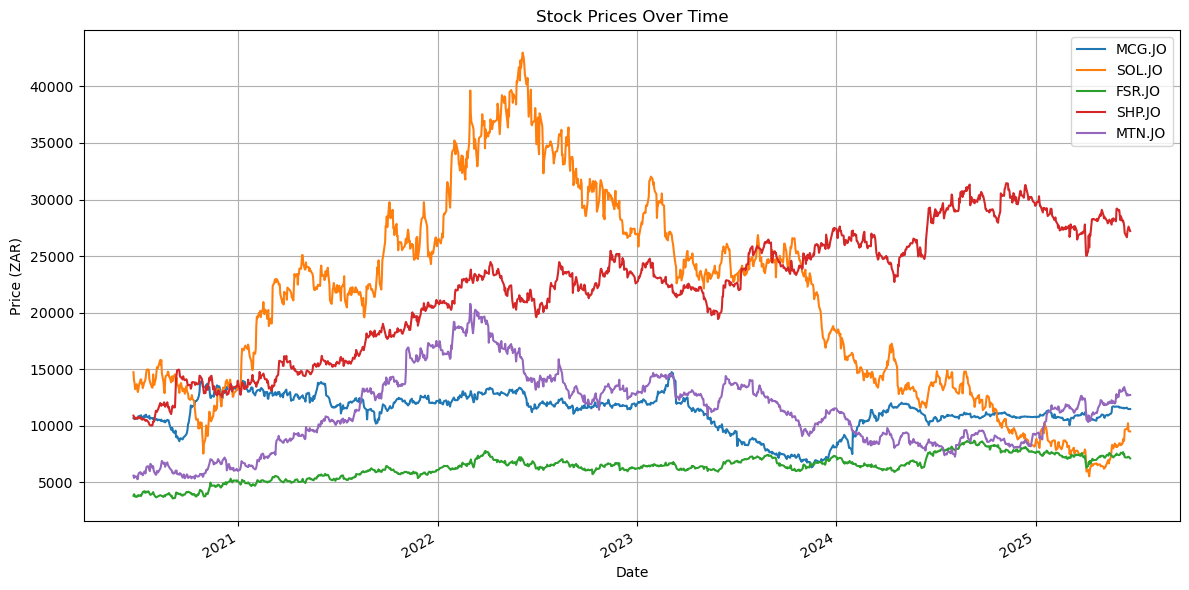

In [6]:
def plot_prices(prices):
    prices.plot(figsize=(12, 6))
    plt.title("Stock Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price (ZAR)")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()
plot_prices(prices)

In [13]:
def adf_test_prices(prices):
    print("\n Augmented Dickey-Fuller (ADF) Test on Raw Prices:\n")
    for column in prices.columns:
        series = prices[column]
        result = adfuller(series)
        test_stat, p_value, used_lags, n_obs, crit_vals = (
            result[0], result[1], result[2], result[3], result[4]
        )
        print(f"--- {column} ---")
        print(f"ADF Statistic     : {test_stat:.4f}")
        print(f"p-value           : {p_value:.4f}")
        print(f"# Lags Used       : {used_lags}")
        print(f"# Observations    : {n_obs}")
        print("Critical Values   :")
        for k, v in crit_vals.items():
            print(f"    {k}: {v:.4f}")
        if p_value < 0.05:
            print("Likely stationary (reject H0)\n")
        else:
            print(" Likely non-stationary (fail to reject H0)\n")
adf_test_prices(prices)


 Augmented Dickey-Fuller (ADF) Test on Raw Prices:

--- MCG.JO ---
ADF Statistic     : -2.2209
p-value           : 0.1987
# Lags Used       : 0
# Observations    : 1248
Critical Values   :
    1%: -3.4356
    5%: -2.8639
    10%: -2.5680
 Likely non-stationary (fail to reject H0)

--- SOL.JO ---
ADF Statistic     : -0.7753
p-value           : 0.8263
# Lags Used       : 12
# Observations    : 1236
Critical Values   :
    1%: -3.4357
    5%: -2.8639
    10%: -2.5680
 Likely non-stationary (fail to reject H0)

--- FSR.JO ---
ADF Statistic     : -2.4540
p-value           : 0.1271
# Lags Used       : 0
# Observations    : 1248
Critical Values   :
    1%: -3.4356
    5%: -2.8639
    10%: -2.5680
 Likely non-stationary (fail to reject H0)

--- SHP.JO ---
ADF Statistic     : -1.8694
p-value           : 0.3466
# Lags Used       : 1
# Observations    : 1247
Critical Values   :
    1%: -3.4356
    5%: -2.8639
    10%: -2.5680
 Likely non-stationary (fail to reject H0)

--- MTN.JO ---
ADF Statist

# TASK 2 : Data Collection and Preprocessing

In [15]:
def compute_log_returns(prices):
    log_returns = np.log(prices / prices.shift(1))
    log_returns.dropna(inplace=True)
    return log_returns

def plot_log_returns(log_returns):
    log_returns.plot(figsize=(12, 6))
    plt.title("Log Returns Time Series")
    plt.xlabel("Date")
    plt.ylabel("Log Return")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()
log_returns = compute_log_returns(prices)
print("\n Log Returns:")
print(log_returns.tail())


 Log Returns:
                             MCG.JO    SOL.JO    FSR.JO    SHP.JO    MTN.JO
Date                                                                       
2025-06-17 00:00:00+02:00  0.004405  0.008251 -0.005413 -0.014151 -0.044761
2025-06-18 00:00:00+02:00 -0.006659  0.003486  0.005551  0.018541  0.011847
2025-06-19 00:00:00+02:00 -0.002172  0.045519  0.004694  0.008724 -0.008538
2025-06-20 00:00:00+02:00 -0.002176 -0.071126  0.000000  0.007454 -0.001023
2025-06-23 00:00:00+02:00  0.000436 -0.002313 -0.019472 -0.014412  0.001731


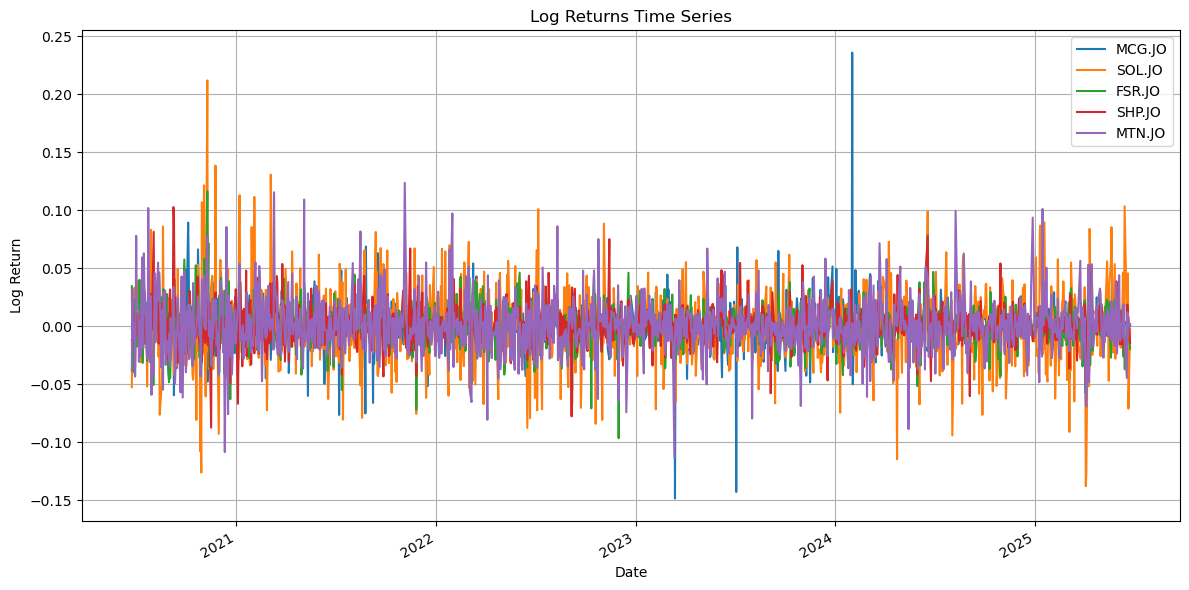

In [17]:
plot_log_returns(log_returns)

**STATIONARITY TEST**

In [19]:
def adf_test_log_returns(log_returns):
    print("\n Augmented Dickey-Fuller (ADF) Test Results:\n")
    for column in log_returns.columns:
        series = log_returns[column]
        result = adfuller(series)
        test_stat, p_value, used_lags, n_obs, crit_vals = result[0], result[1], result[2], result[3], result[4]
        print(f"--- {column} ---")
        print(f"ADF Statistic     : {test_stat:.4f}")
        print(f"p-value           : {p_value:.4f}")
        print(f"# Lags Used       : {used_lags}")
        print(f"# Observations    : {n_obs}")
        print("Critical Values   :")
        for k, v in crit_vals.items():
            print(f"    {k}: {v:.4f}")
        if p_value < 0.05:
            print(" The series is likely stationary (reject H0)\n")
        else:
            print(" The series is likely non-stationary (fail to reject H0)\n")

adf_test_log_returns(log_returns)



 Augmented Dickey-Fuller (ADF) Test Results:

--- MCG.JO ---
ADF Statistic     : -13.5159
p-value           : 0.0000
# Lags Used       : 5
# Observations    : 1242
Critical Values   :
    1%: -3.4356
    5%: -2.8639
    10%: -2.5680
 The series is likely stationary (reject H0)

--- SOL.JO ---
ADF Statistic     : -22.1891
p-value           : 0.0000
# Lags Used       : 2
# Observations    : 1245
Critical Values   :
    1%: -3.4356
    5%: -2.8639
    10%: -2.5680
 The series is likely stationary (reject H0)

--- FSR.JO ---
ADF Statistic     : -15.4583
p-value           : 0.0000
# Lags Used       : 6
# Observations    : 1241
Critical Values   :
    1%: -3.4356
    5%: -2.8639
    10%: -2.5680
 The series is likely stationary (reject H0)

--- SHP.JO ---
ADF Statistic     : -35.9293
p-value           : 0.0000
# Lags Used       : 0
# Observations    : 1247
Critical Values   :
    1%: -3.4356
    5%: -2.8639
    10%: -2.5680
 The series is likely stationary (reject H0)

--- MTN.JO ---
ADF St

# TASK 3 : Principal Component Analysis (PCA)

In [25]:
def apply_pca(log_returns):
    if log_returns.empty:
        raise ValueError("Log returns data is empty.")
    scaler = StandardScaler()
    scaled = scaler.fit_transform(log_returns)
    pca = PCA(n_components=log_returns.shape[1])
    pcs = pca.fit_transform(scaled)
    explained_var = pd.DataFrame({
        'PC': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
        'Variance Explained': pca.explained_variance_ratio_
    })
    return pca, pcs, explained_var
#PCA
pca_model, pcs, explained_variance_df = apply_pca(log_returns)
print("\n PCA Explained Variance:")
print(explained_variance_df)


 PCA Explained Variance:
    PC  Variance Explained
0  PC1            0.411222
1  PC2            0.183919
2  PC3            0.164702
3  PC4            0.138122
4  PC5            0.102036


**Extracting Leading Factor**

In [37]:
# Get the principal components (factor loadings)
loadings = pd.DataFrame(pca_model.components_.T, 
                        index=log_returns.dropna().columns, 
                        columns=[f'PC{i+1}' for i in range(len(log_returns.dropna().columns))])

print("\nFactor Loadings (First Few PCs):")
print(loadings.iloc[:, :5])


Factor Loadings (First Few PCs):
             PC1       PC2       PC3       PC4       PC5
MCG.JO  0.290168  0.922304  0.004431 -0.251187  0.045202
SOL.JO  0.391511 -0.202335  0.838145 -0.297679 -0.121161
FSR.JO  0.543847 -0.217160 -0.204418 -0.031685  0.783761
SHP.JO  0.482010 -0.232124 -0.503182 -0.402682 -0.546297
MTN.JO  0.484167  0.085882  0.050152  0.827729 -0.265622


**SCREE PLOT FOR VARIANCE**

**1.** The Elbow Method

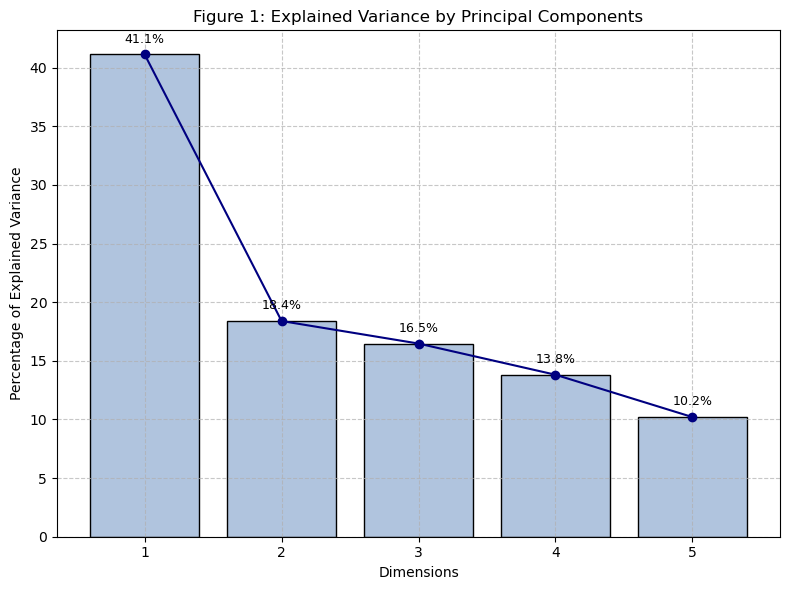

In [44]:
# Bar heights: variance explained by each PC
explained_var = pca_model.explained_variance_ratio_
components = np.arange(1, len(explained_var) + 1)

plt.figure(figsize=(8, 6))
bars = plt.bar(components, explained_var * 100, color='lightsteelblue', edgecolor='black')
plt.plot(components, explained_var * 100, marker='o', linestyle='-', color='navy')

plt.title("Figure 1: Explained Variance by Principal Components")
plt.xlabel("Dimensions")
plt.ylabel("Percentage of Explained Variance")
plt.xticks(components)
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate bar heights (like your figure)
for i, v in enumerate(explained_var * 100):
    plt.text(i + 1, v + 1, f"{v:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

**2.** Kaizer's Rule

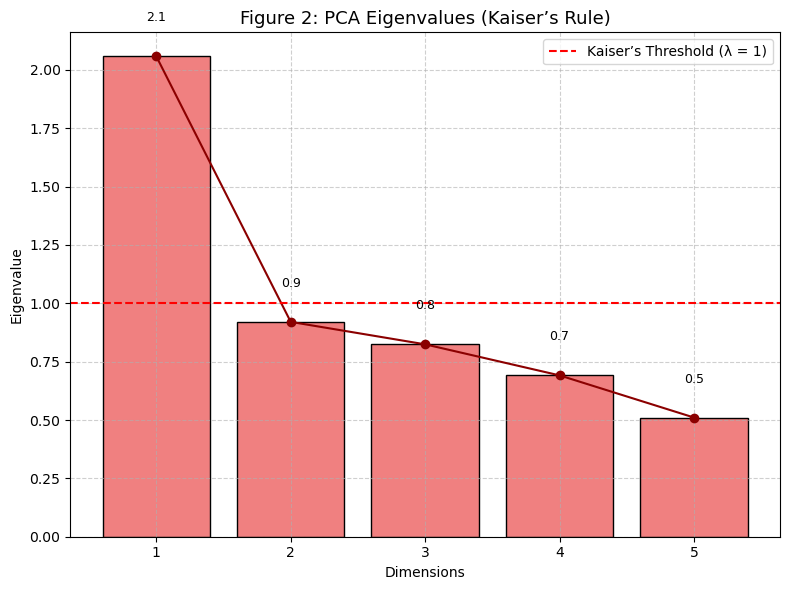

In [49]:
# Extract eigenvalues and component indices
eigenvalues = pca_model.explained_variance_
components = np.arange(1, len(eigenvalues) + 1)

plt.figure(figsize=(8, 6))

# Bar plot of eigenvalues
bars = plt.bar(components, eigenvalues, color='lightcoral', edgecolor='black')

# Line connecting tops of bars
plt.plot(components, eigenvalues, marker='o', linestyle='-', color='darkred')

# Kaiser’s rule threshold line
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label="Kaiser’s Threshold (λ = 1)")

# Annotate each eigenvalue
for i, val in enumerate(eigenvalues):
    plt.text(i + 1, val + 0.15, f"{val:.1f}", ha='center', fontsize=9)

plt.title("Figure 2: PCA Eigenvalues (Kaiser’s Rule)", fontsize=13)
plt.xlabel("Dimensions")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# TASK 4: GARCH Modelling on Orthogonal Factors

In [82]:
garch_models = []
garch_fits = []
pcs_3 = pcs[:, :3] 
for i in range(pcs_3.shape[1]):
    factor = pcs_3[:, i]
    am = arch_model(factor, mean='Zero', vol='GARCH', p=1, q=1)
    res = am.fit(disp='off')

    print(f"\n GARCH(1,1) results for PC{i+1}")
    print(res.summary())

    garch_models.append(am)
    garch_fits.append(res)


 GARCH(1,1) results for PC1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2189.20
Distribution:                  Normal   AIC:                           4384.40
Method:            Maximum Likelihood   BIC:                           4399.78
                                        No. Observations:                 1248
Date:                Mon, Jun 23 2025   Df Residuals:                     1248
Time:                        20:41:53   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2950      0.166

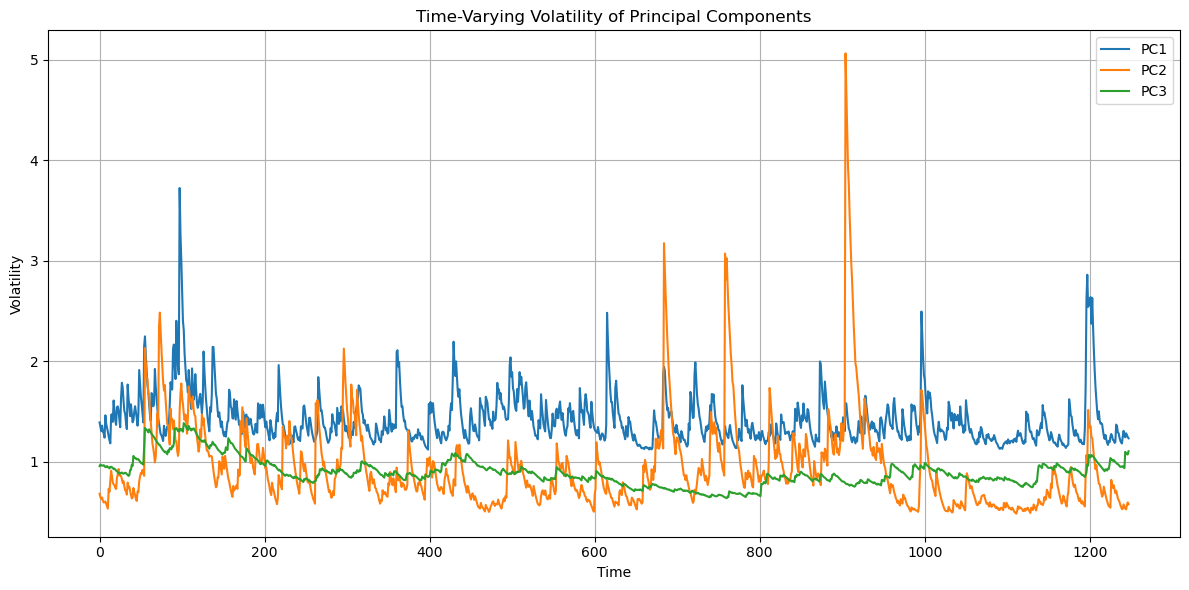

In [54]:
cond_vars = np.array([fit.conditional_volatility ** 2 for fit in garch_fits]).T
cond_vols = np.sqrt(cond_vars)
def plot_pca_volatilities(cond_vols):
    num_factors = cond_vols.shape[1]
    plt.figure(figsize=(12, 6))
    for i in range(num_factors):
        plt.plot(cond_vols[:, i], label=f'PC{i+1}')
    plt.title("Time-Varying Volatility of Principal Components")
    plt.xlabel("Time")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pca_volatilities(cond_vols)

# TASK 5 : Reconstruction of the Conditional Covariance Matrix

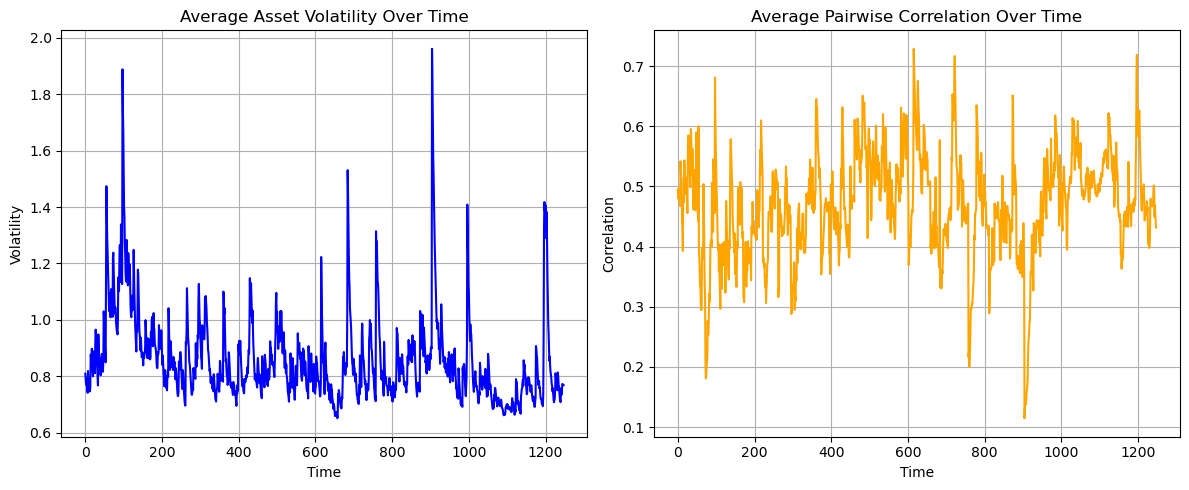

In [61]:
def reconstruct_covariance_matrix(pca, garch_fits):
    """
    Reconstruct time-varying covariance matrices using PCA loadings
    and GARCH conditional variances from selected principal components.
    """
    cond_vars = np.array([fit.conditional_volatility**2 for fit in garch_fits]).T
    P = pca.components_.T[:, :len(garch_fits)]
    cov_matrices = [P @ np.diag(var) @ P.T for var in cond_vars]
    return np.array(cov_matrices)
cov_matrices = reconstruct_covariance_matrix(pca_model, garch_fits)

def visualize_volatility_and_correlation(cov_matrices):
    """
    Plot time series of average volatility and average correlation
    from the reconstructed covariance matrices.
    """
    volatilities = np.sqrt(np.diagonal(cov_matrices, axis1=1, axis2=2))
    avg_vol = volatilities.mean(axis=1)
    
    correlations = []
    for cov in cov_matrices:
        stddev = np.sqrt(np.diag(cov))
        corr = cov / np.outer(stddev, stddev)
        np.fill_diagonal(corr, np.nan)
        correlations.append(np.nanmean(corr))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(avg_vol, color='blue')
    plt.title("Average Asset Volatility Over Time")
    plt.xlabel("Time")
    plt.ylabel("Volatility")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(correlations, color='orange')
    plt.title("Average Pairwise Correlation Over Time")
    plt.xlabel("Time")
    plt.ylabel("Correlation")
    plt.grid(True)

    plt.tight_layout()
    plt.show()
visualize_volatility_and_correlation(cov_matrices)

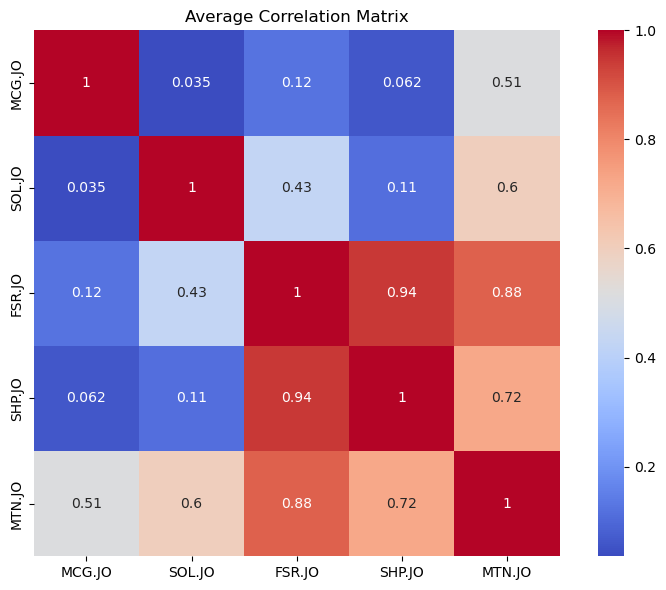

,MCG.JO,SOL.JO,FSR.JO,SHP.JO,MTN.JO
MCG.JO,1.000000,0.035471,0.124500,0.061524,0.511429
SOL.JO,0.035471,1.000000,0.429277,0.113130,0.598356
FSR.JO,0.124500,0.429277,1.000000,0.944135,0.878477
SHP.JO,0.061524,0.113130,0.944135,1.000000,0.724331
MTN.JO,0.511429,0.598356,0.878477,0.724331,1.000000


In [63]:
import seaborn as sns
def visualize_correlation_matrix(cov_matrices, tickers):
    avg_cov = np.mean(cov_matrices, axis=0)
    D_inv = np.diag(1 / np.sqrt(np.diag(avg_cov)))
    corr_matrix = D_inv @ avg_cov @ D_inv
    corr_df = pd.DataFrame(corr_matrix, index=tickers, columns=tickers)

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', square=True)
    plt.title("Average Correlation Matrix")
    plt.tight_layout()
    plt.show()

    return corr_df

visualize_correlation_matrix(cov_matrices, tickers)

# Task 6 : Portfolio Volatility Forecasting

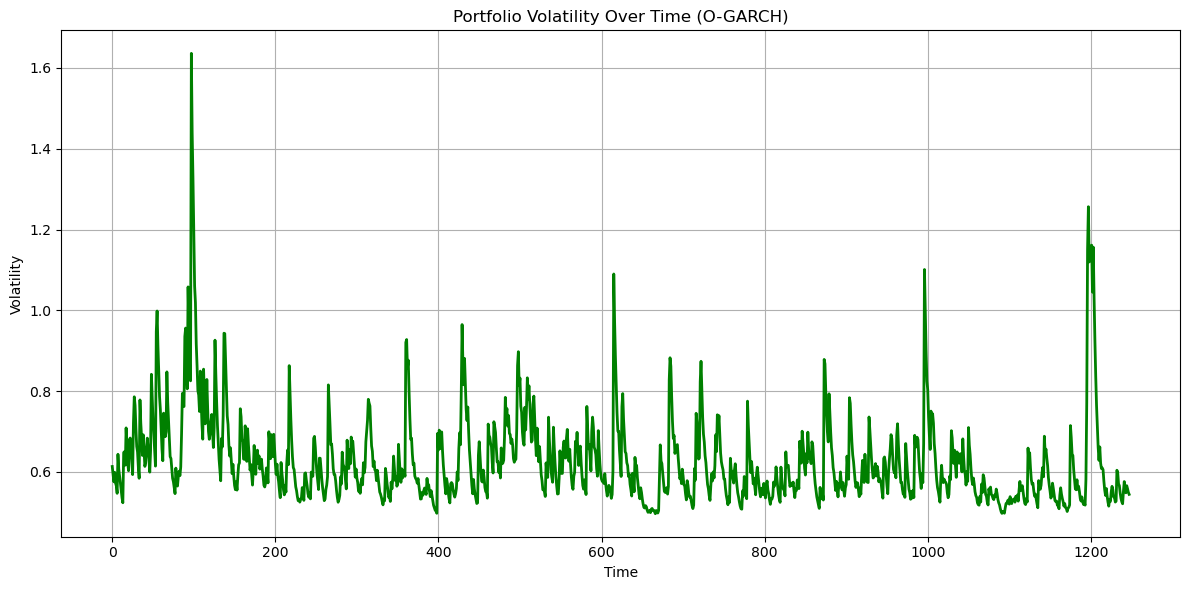

In [68]:
def forecast_portfolio_volatility(cov_matrices, weights):
    w = np.array(weights).reshape(-1, 1)
    w /= w.sum()
    var = np.array([w.T @ cov @ w for cov in cov_matrices]).flatten()
    return np.sqrt(var)

# === Visualization ===
def visualize_volatility(vol_series, label="Portfolio Volatility"):
    plt.figure(figsize=(12, 6))
    plt.plot(vol_series, color='green', linewidth=2)
    plt.title(f"{label} Over Time (O-GARCH)")
    plt.xlabel("Time")
    plt.ylabel("Volatility")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
equal_weights = np.ones(len(tickers)) / len(tickers)
portfolio_vol = forecast_portfolio_volatility(cov_matrices, equal_weights)
visualize_volatility(portfolio_vol)